In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

In [12]:
intrusion_df = pd.read_csv("cybersecurity_intrusion_data.csv")
cloud_df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
global_df = pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")

In [13]:
X = intrusion_df.drop(columns=["attack_detected","session_id"])
y = intrusion_df["attack_detected"]

In [14]:
num_cols = ["network_packet_size","login_attempts","session_duration",
            "ip_reputation_score","failed_logins","unusual_time_access"]
cat_cols = ["protocol_type","encryption_used","browser_type"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [16]:
models = {
    "LogReg": LogisticRegression(max_iter=200),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM_Linear": SVC(kernel="linear", probability=True),
    "SVM_RBF": SVC(kernel="rbf", probability=True),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "NeuralNet": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
}

In [17]:
results = []

import scipy.sparse

for name, model in models.items():
    if name == "NaiveBayes":
        # NB needs dense input
        pipe = Pipeline([
            ("prep", preprocess),
            ("to_dense", FunctionTransformer(lambda X: X.toarray() if scipy.sparse.issparse(X) else X, accept_sparse=True)),
            ("clf", model)
        ])
    else:
        pipe = Pipeline([("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", zero_division=0)
    results.append((name, acc, pr, rc, f1))
    print(f"{name}: Acc={acc:.3f}, Prec={pr:.3f}, Rec={rc:.3f}, F1={f1:.3f}")

LogReg: Acc=0.729, Prec=0.728, Rec=0.729, F1=0.727
KNN: Acc=0.793, Prec=0.803, Rec=0.793, F1=0.788
SVM_Linear: Acc=0.732, Prec=0.732, Rec=0.732, F1=0.729
SVM_RBF: Acc=0.873, Prec=0.887, Rec=0.873, F1=0.870
NaiveBayes: Acc=0.811, Prec=0.827, Rec=0.811, F1=0.806
DecisionTree: Acc=0.883, Prec=0.901, Rec=0.883, F1=0.880
RandomForest: Acc=0.882, Prec=0.899, Rec=0.882, F1=0.879
NeuralNet: Acc=0.849, Prec=0.854, Rec=0.849, F1=0.847


C:\Users\Aman Deep Singh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


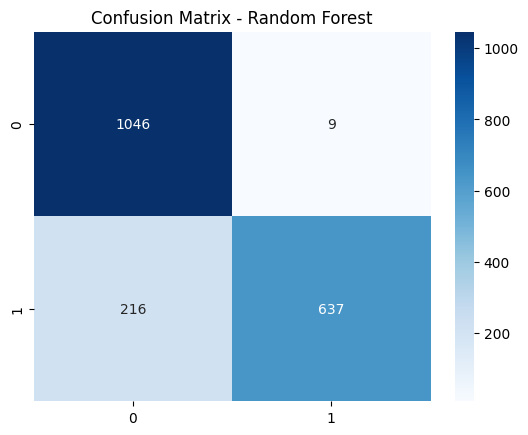

In [18]:
rf = Pipeline([("prep", preprocess), ("clf", models["RandomForest"])])
rf.fit(X_train, y_train)
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [19]:
iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
cloud_df["anomaly_label"] = iso.fit_predict(cloud_df[["bytes_in","bytes_out"]])
print("Isolation Forest anomaly rate:", (cloud_df["anomaly_label"]==-1).mean())

Isolation Forest anomaly rate: 0.05319148936170213


K-Means silhouette: 0.5733577453359046


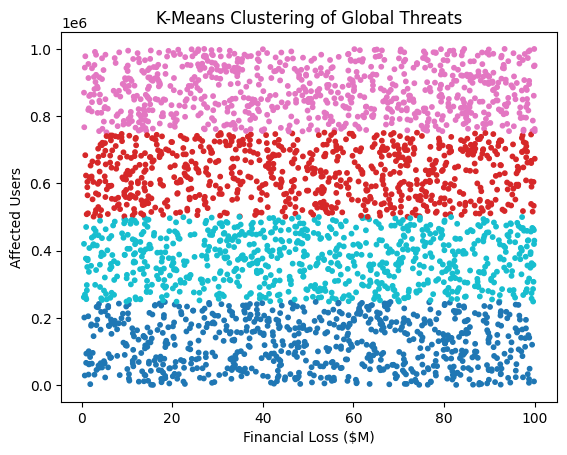

In [20]:
Xg = global_df[["Financial Loss (in Million $)", "Number of Affected Users"]].dropna()

kmeans = KMeans(n_clusters=4, random_state=42)
global_df["kmeans_cluster"] = kmeans.fit_predict(Xg)
print("K-Means silhouette:", silhouette_score(Xg, global_df["kmeans_cluster"]))

agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
global_df["hier_cluster"] = agg.fit_predict(Xg)

plt.scatter(Xg.iloc[:,0], Xg.iloc[:,1], c=global_df["kmeans_cluster"], cmap="tab10", s=10)
plt.xlabel("Financial Loss ($M)")
plt.ylabel("Affected Users")
plt.title("K-Means Clustering of Global Threats")
plt.show()